# FreeTrace tutorial

# Requirements
FreeTrace requires Linux platform to infer fully the molecular trajectories.</br>
- CUDA accelerates the localisation of molecules from video if you have a NVIDIA GPU in your machine.</br>
- Cuda installation: [Nvidia Cuda installation](https://developer.nvidia.com/cuda-toolkit)</br>
  
You can run FreeTrace without a GPU; however, it'll be very slow if you try to infer the trajectories with fBm mode.</br>
In the case of high molecular density in a heterogeneous medium, we recommend running FreeTrace on a GPU-equipped machine for the best inference result.</br>

# Compatibility

![convert notebook to web app](tmps/compatibility_table.png)

# FreeTrace installation
After downloading FreeTrace, the import of FreeTrace.installation (shown in below cell) will download additional DNN models, packages and compile to run FreeTrace.</br>
This step probably overrides your current versions of packages. Please check [requirements.txt](FreeTrace/requirements.txt).</br>
If you don't want to upgrade your packages to the latest version, please install them manually.</br>
FreeTrace utilises Tensorflow 2.14/2.17 to run it with source code and infer the trajectories under fractional Brownian motion.</br>
Once the installation is successfully finished, you don't need to re-import the FreeTrace.installation for the installation of packages.</br>
#### Please delete the below cell after installation is finished to prevent re-installation when you run this notebook again!

In [ ]:
#!pip3 install FreeTrace
import FreeTrace.installation

# FreeTrace algorithm

FreeTrace consists of two major algorithms.
- Localisation of particles from video.</br>
- Reconnection of localised particles .</br>
The units of FreeTrace output are <b>pixels</b> (coordinates) and <b>frames</b> (time). To analyse the result with your microscopy setting, you need to convert the data into micrometres/nanometers and milliseconds.</br>

The detailed algorithm of FreeTrace will be available soon.

### -----------------------------------------------------------------------------------------------------------------------------

# 1. Parameter settings
Below is the parameters of FreeTrace.</br>

In [1]:
from FreeTrace import Tracking, Localization

"""
Path of input video and output results.
"""
video_name = 'inputs/sample0.tiff'  # input video.tiff path.
output_dir = 'outputs'  # output path.
verbose = 1  # print ETA of process if verbose=1, 0 otherwise.


"""
Basic parameters.
"""
window_size = 7  # Length (pixel) of sliding window to localize molecules from video
threshold = 1.0  # Threshold factor to determine the existence of a molecule inside sliding windows, base thresholds are calculated with SNR of images.
cutoff = 3  # Minimum length of trajectory for the output.


"""
Advanced parameters.
"""
gpu_for_localization = True  # GPU acceleration of localization if True, False otherwise.
realtime_localization = False  # Real-time visulaization of localization if True, False otherwise.
save_localization_video = False  # Save the visualized localization in tiff format (requires enough RAM).

fBm_mode = True  # Tracking under fBm if True (slow). Otherwise, FreeTrace infers the trajectories under classical Brownian motion.
jump_threshold = None  # Maximum jump distance of molecules for 1 frame. If None, FreeTrace estimates it automatically with GMM.
graph_depth = 2  # Number of frames for the inference of trajectories at each step, between 1 and 5 inclusive. A higher number will slow down the speed.
realtime_tracking = False  # Real-time visulaization of tracking if True, False otherwise.
save_tracking_video = False  # Save the visualized trajectories in tiff format (requires enough RAM).

# 2. Localization

- Run the localization of molecules from video with pre-difined parameters above.</br>
- Tracking.run_process() returns True if it finishes successfully.

In [2]:
loc = Localization.run_process(input_video_path=video_name,
                               output_path=output_dir,
                               window_size=window_size,
                               threshold=threshold,
                               gpu_on=gpu_for_localization,
                               save_video=save_localization_video, 
                               realtime_visualization=realtime_localization,
                               verbose=verbose)

2025-09-23 15:06:34.802140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-23 15:06:34.879310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-23 15:06:34.901810: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-23 15:06:35.047991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 15:06:36.184409: W tensorflow/compiler/tf2


******************************** OPTIONS *****************************************
*********                Cuda: O, Localization with GPU.                 *********
**********************************************************************************



I0000 00:00:1758632797.071219    6714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758632797.238423    6714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758632797.238543    6714 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
Localization: 100%|████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 57.51frame/s]


# 3. Trajectory inference

- Run the tracking of localized molecules from video and localization results, with pre-defined parameters above.</br>
- Tracking.run_process() returns True if it finishes successfully.

In [3]:
track = Tracking.run_process(input_video_path=video_name,
                             output_path=output_dir,
                             graph_depth=graph_depth,
                             cutoff=cutoff,
                             jump_threshold=jump_threshold,
                             gpu_on=fBm_mode,
                             save_video=save_tracking_video,
                             realtime_visualization=realtime_tracking,
                             verbose=verbose)

2025-09-23 15:06:44.368670: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-23 15:06:44.378360: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-23 15:06:44.381347: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-23 15:06:44.389430: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-23 15:06:45.108347: W tensorflow/compiler/tf2


******************************** OPTIONS *****************************************
*********       Tensorflow: O, Tracking with GPU if fBm_mode is ON.      *********
**********************************************************************************



I0000 00:00:1758632805.568518    6848 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758632805.602803    6848 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758632805.602900    6848 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758632805.705779    6848 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1758632805.705884    6848 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

Mean nb of particles per frame: 19.04 particles/frame


Tracking:   0%|                                                                              | 0/100 [00:00<?, ?frame/s]/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Tracking:   6%|████▏                                                                 | 6/100 [00:00<00:03, 30.36frame/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1758632813.486265    6959 service.cc:146] XLA service 0x1fd1baa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758632813.486307    6959 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-09-23 15:06:53.512816: I external/

Once the localization and tracking of FreeTrace finish successfully, you can find the molecular trajectory file in your output directory with the name <b>video_traces.csv</b>.</br></br>
If your trajectory is heterogeneous, you need an additional inference with a program of your choice to segment the trajectory.</br>
Below are the simple analysis steps of trajectory data. We assumed that your trajectory is homogeneous or already segmented with your preferred software.</br>

# 4. Load trajectory data

In [4]:
from FreeTrace.module.data_load import read_csv, read_multiple_csv
trajectory_data = read_csv(file='outputs/sample0_traces.csv')
#trajectory_data = read_multiple_csv('outputs')
trajectory_data

,traj_idx,frame,x,y,z,state
0,0,26,76.694749,54.818897,6.931740e-310,0
1,0,28,75.835419,54.806431,1.914949e-315,0
2,0,29,73.202596,52.991906,0.000000e+00,0
3,1,19,36.141905,69.111857,0.000000e+00,0
4,1,20,36.201043,69.883163,4.940656e-324,0
...,...,...,...,...,...,...
1651,174,69,82.615350,81.268227,8.596742e-322,0
1652,175,26,40.962664,36.797368,8.646149e-322,0
1653,175,28,43.257812,37.964984,8.646149e-322,0
1654,175,29,41.849590,36.118522,8.646149e-322,0


# 5. Simple analysis of trajectory

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
from FreeTrace.module.preprocessing import simple_preprocessing

"""
Option settings for data analysis.
"""
PIXELMICRONS = 0.16
FRAMERATE = 0.01
CUTOFF = 5  # minimum length of trajectory to consider for the analysis.
number_of_bins = 50
figure_resolution_in_dpi = 200
figure_font_size = 20


"""
Preprocessing generates 4 data.
@params: data folder path, pixel microns, frame rate, cutoff
@output: Analysis_data1(pd.DataFrame), Analysis_data2(pd.DataFrame), MSD(pd.DataFrame), TAMSD(pd.DataFrame)

Simple_preprocessing includes below steps.
1. Exclude the trajectory where the length is shorter than CUTOFF
2. Convert from pixel unit to micrometre unit with PIXELMICRONS and FRAMERATE
3. Generate 4 DataFrames.
"""
analysis_data1, analysis_data2, analysis_data3, msd, tamsd = simple_preprocessing(data=trajectory_data,
                                                                                  pixelmicrons=PIXELMICRONS,
                                                                                  framerate=FRAMERATE,
                                                                                  cutoff=CUTOFF)

print(f'\nanalysis_data1:\n', analysis_data1)
print(f'\nanalysis_data2:\n', analysis_data2)
print(f'\nanalysis_data3:\n', analysis_data3)
print(f'\nMSD:\n', msd)
print(f'\nEnsemble-averaged TAMSD:\n', tamsd)

** Computing of Ensemble-averaged TAMSD takes a few minutes **


Analysis: 100%|██████████████████████████████████████████████████████████████| 176/176 [00:00<00:00, 340.53trajectory/s]
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/junwoo/venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


** preprocessing finished **

analysis_data1:
      mean_jump_d  state  duration traj_id color
0       0.123455      0      0.13       1   red
1       0.407361      0      0.04       2   red
2       0.271486      0      0.12       3   red
3       0.061299      0      0.10       4   red
4       0.184544      0      0.05       5   red
..           ...    ...       ...     ...   ...
103     0.080224      0      0.11     164   red
104     0.041943      0      0.10     170   red
105     0.101817      0      0.07     171   red
106     0.053667      0      0.20     172   red
107     0.220961      0      0.12     173   red

[108 rows x 5 columns]

analysis_data2:
       displacements  state
0          0.123771      0
1          0.287741      0
2          0.013382      0
3          0.144990      0
4          0.280194      0
...             ...    ...
1307       0.181464      0
1308       0.132320      0
1309       0.515551      0
1310       0.199245      0
1311       0.146972      0

[1312 rows

# 6. Plots of analysed trajectory data.</br>
Data is stored as</br>
1. analysis_data1: (DataFrame: contains data of mean_jump_distance, duration, traj_id, color_code)</br>
2. analysis_data2: (DataFrame: contains data of displacments, color_code)</br>
3. msd: (DataFrame: contains msd.) </br>
4. tamsd: (DataFrame: contains ensemble-averaged tamsd.) </br>

Units: </br>
mean jump-distance: set of averages of jump distances in um.</br>
duration: duration of trajectory in seconds.</br>
displacement: displacement(time lag=1) of all trajectories in um.</br>

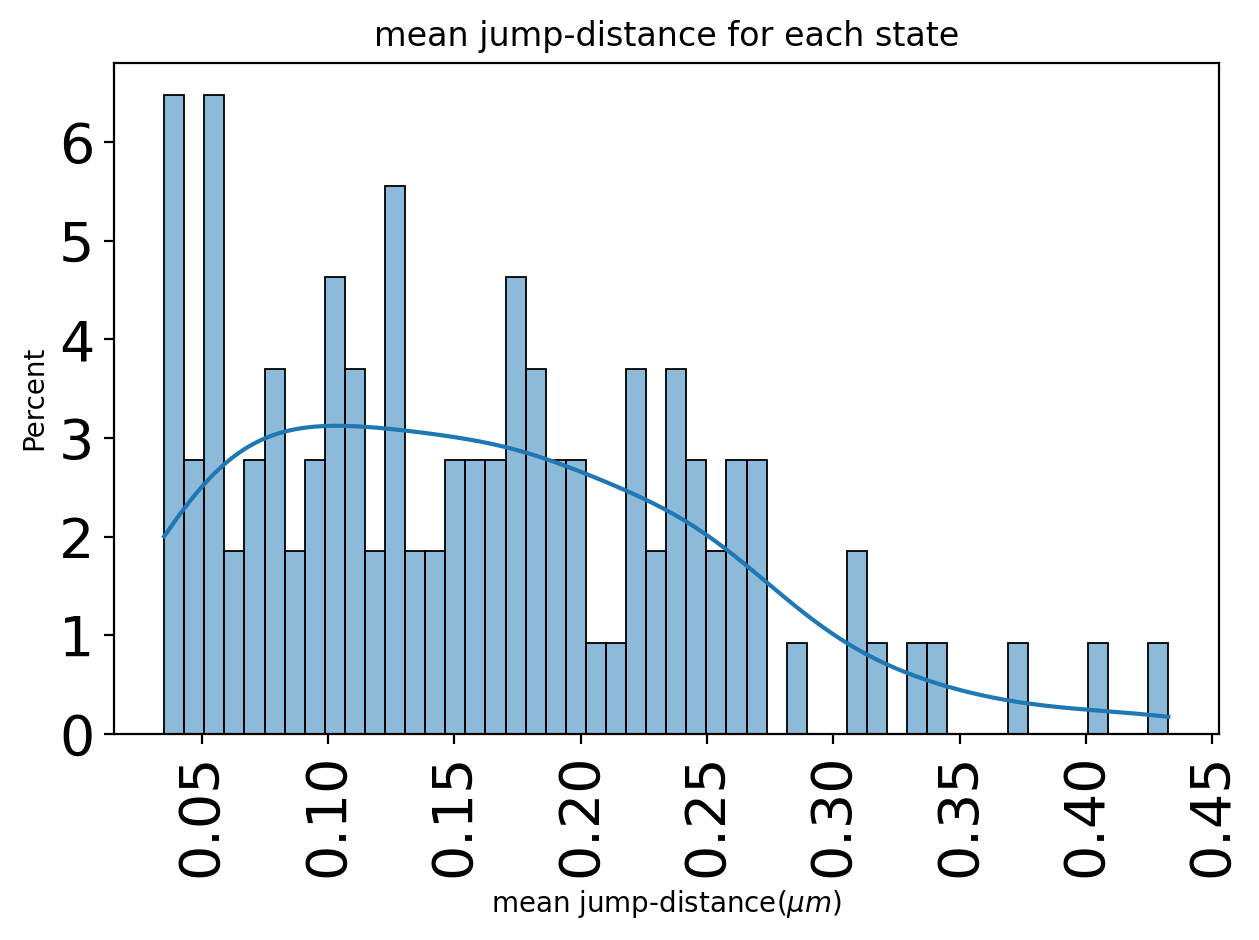

In [6]:
#p1: histogram with kde(kernel density estimation) plot of mean jump distance grouped by state.
plt.figure(f'p1', dpi=figure_resolution_in_dpi)
p1 = sns.histplot(analysis_data1, x=f'mean_jump_d', stat='percent', bins=number_of_bins, kde=True)
p1.set_xlabel(r'mean jump-distance($\mu m$)')
p1.set_title(f'mean jump-distance for each state')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

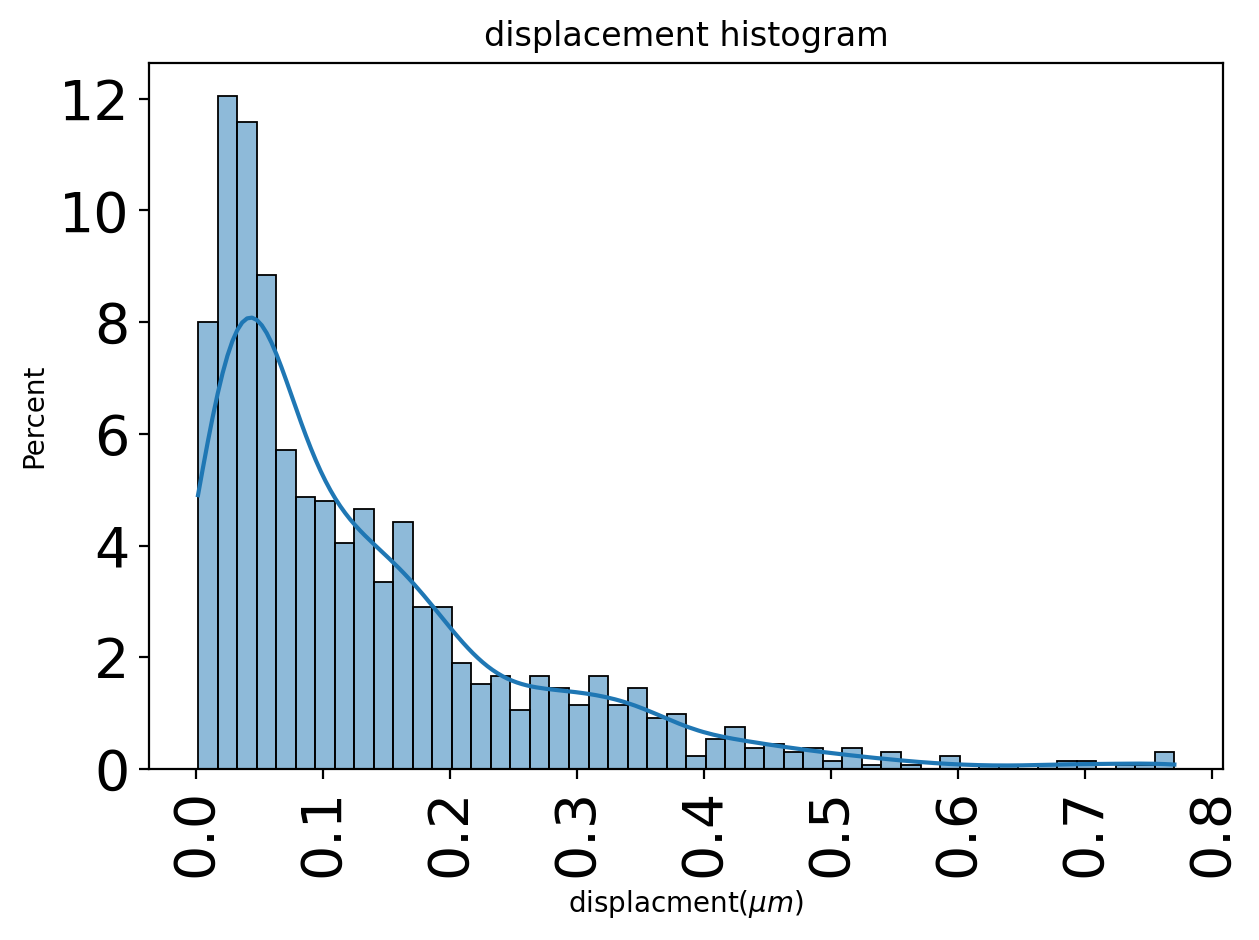

In [7]:
#p2: displacement histogram
plt.figure(f'p2', dpi=figure_resolution_in_dpi)
p2 = sns.histplot(data=analysis_data2, x='displacements', stat='percent', bins=number_of_bins, kde=True)
p2.set_title(f'displacement histogram')
p2.set_xlabel(r'displacment($\mu m$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

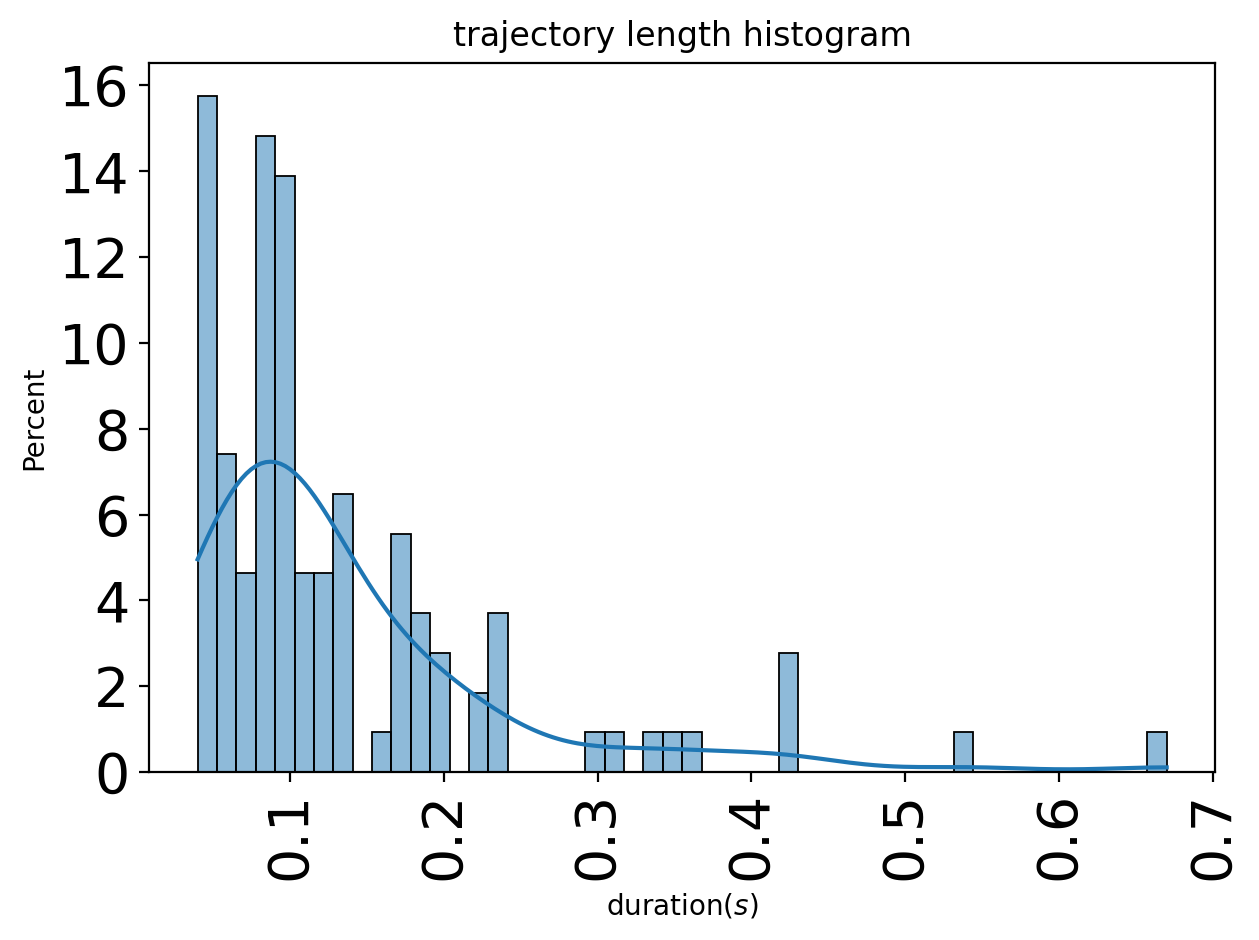

In [8]:
#p3: trajectory length(sec) histogram
plt.figure(f'p3', dpi=figure_resolution_in_dpi)
p3 = sns.histplot(data=analysis_data1, x='duration', stat='percent', bins=number_of_bins, kde=True)
p3.set_title(f'trajectory length histogram')
p3.set_xlabel(r'duration($s$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

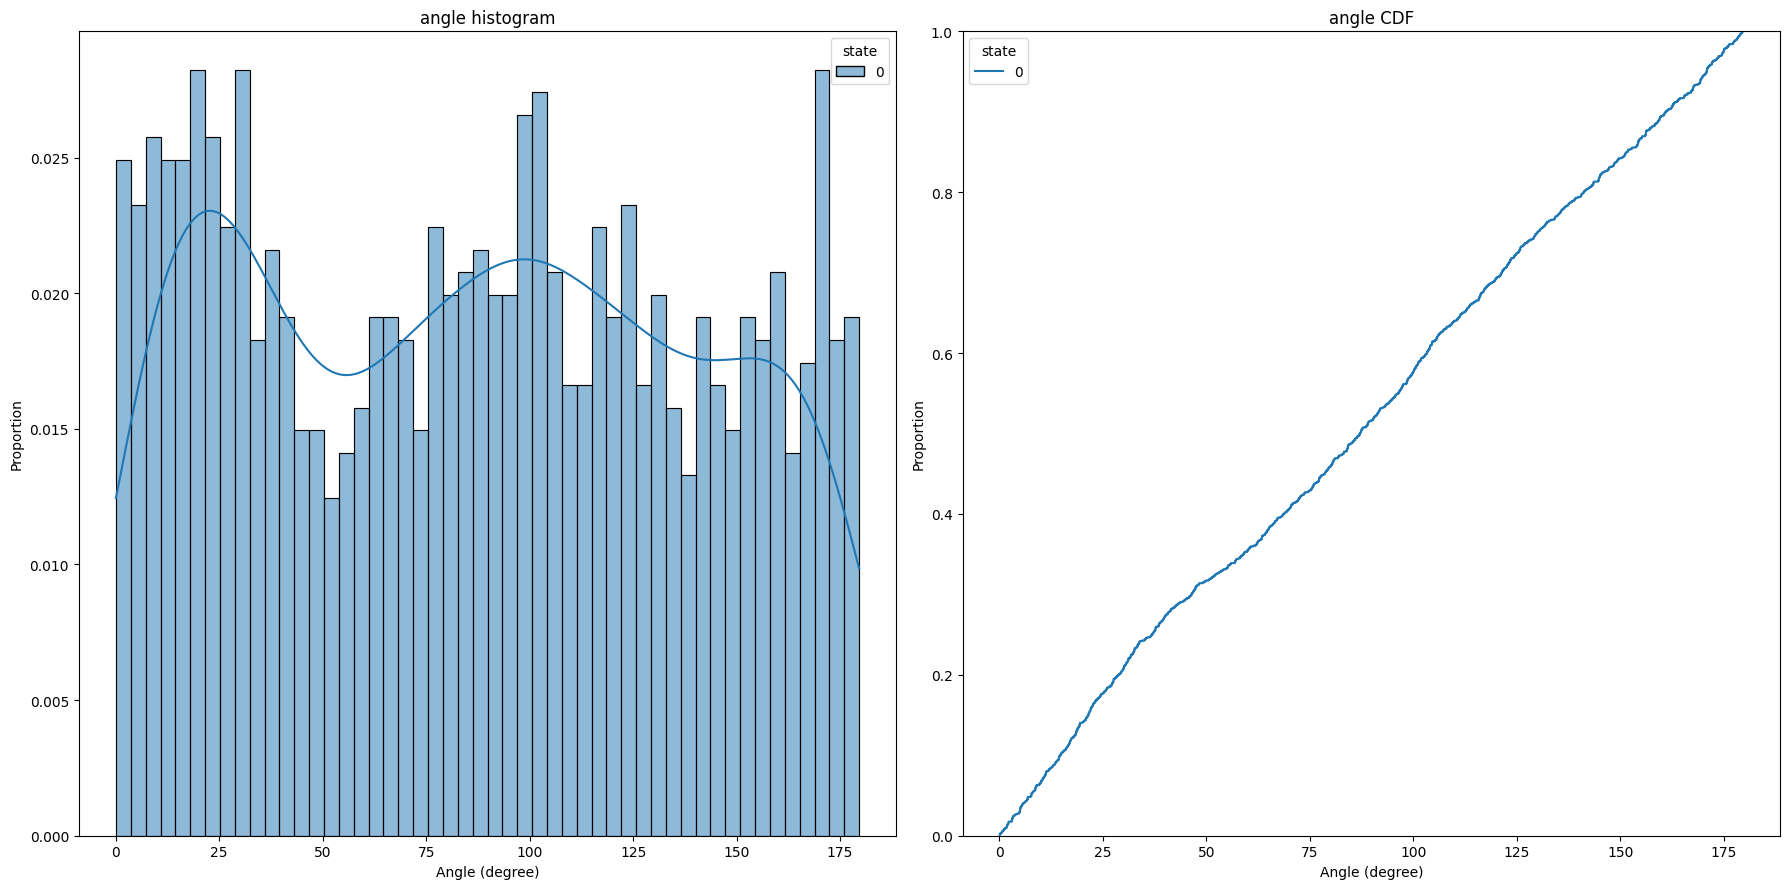

In [10]:
#p4: angles histogram
fig, axs = plt.subplots(1, 2, num=f'p13', figsize=(18, 9))
sns.histplot(data=analysis_data3, x='angles', stat='proportion', hue='state', common_norm=False, bins=number_of_bins, kde=True, ax=axs[0], kde_kws={'bw_adjust': 1})
sns.ecdfplot(data=analysis_data3, x='angles', stat='proportion', hue='state', ax=axs[1])
axs[0].set_title(f'angle histogram')
axs[0].set_xlabel(r'Angle (degree)')
axs[1].set_title(f'angle CDF')
axs[1].set_xlabel(r'Angle (degree)')
plt.tight_layout()

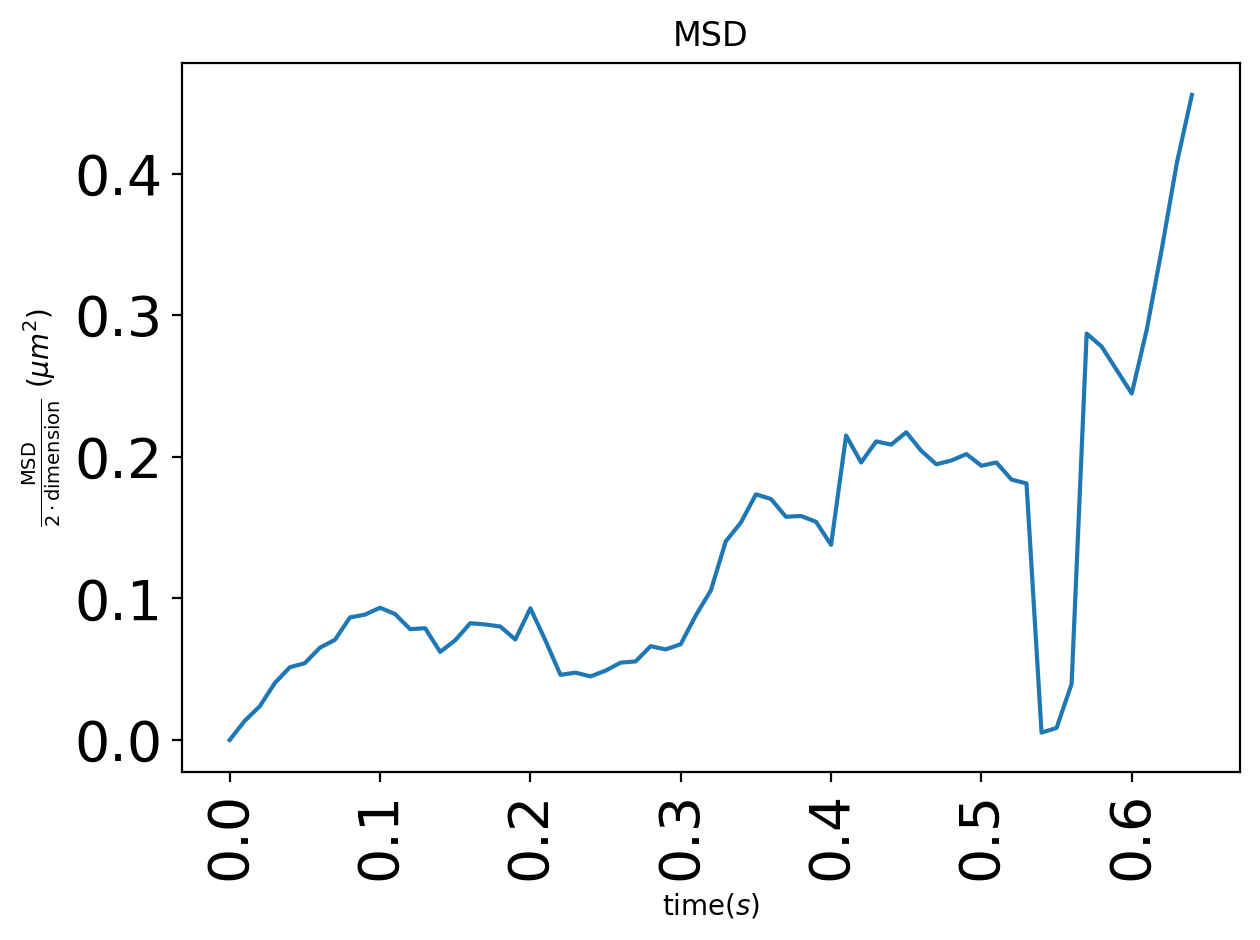

In [11]:
#p5: MSD
plt.figure(f'p5', dpi=figure_resolution_in_dpi)
p4 = sns.lineplot(data=msd, x=msd['time'], y=msd['mean'])
p4.set_title(f'MSD')
p4.set_xlabel(r'time($s$)')
p4.set_ylabel(r'$\frac{\text{MSD}}{\text{2} \cdot \text{dimension}}$ ($\mu m^2$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()

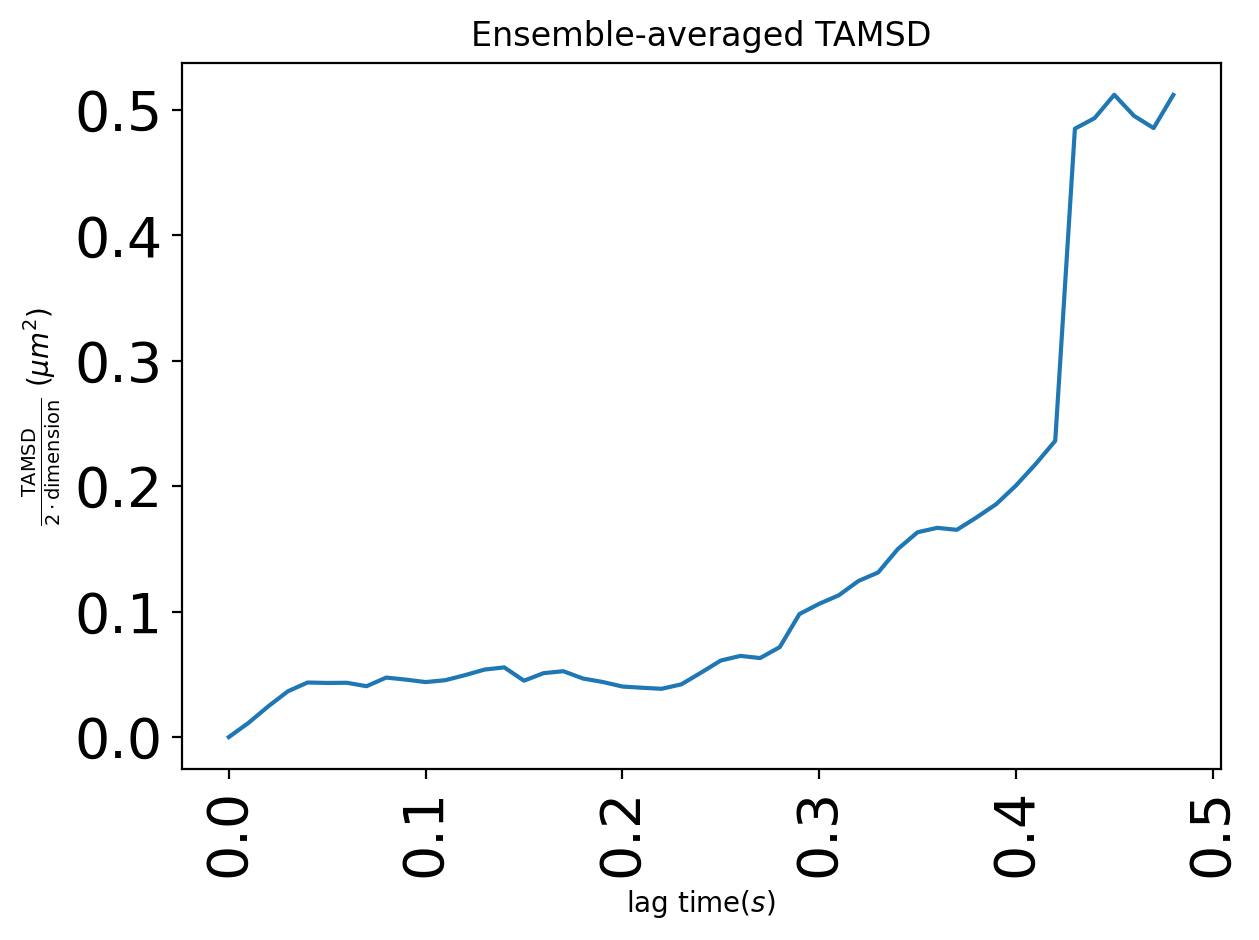

In [12]:
#p6: Ensemble-averaged TAMSD
plt.figure(f'p6', dpi=figure_resolution_in_dpi)
p5 = sns.lineplot(data=tamsd, x=tamsd['time'], y=tamsd['mean'])
p5.set_title(f'Ensemble-averaged TAMSD')
p5.set_xlabel(r'lag time($s$)')
p5.set_ylabel(r'$\frac{\text{TAMSD}}{\text{2} \cdot \text{dimension}}$ ($\mu m^2$)')
plt.yticks(fontsize=figure_font_size)
plt.xticks(fontsize=figure_font_size)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()